# IDP MD Trajectory Clustering with Python
##### DELL jw chem 96 (robustelli) final project
##### 14 March 2022

[TTClust](https://github.com/tubiana/TTClust)

[final project repo](https://www.github.com/j-w-dell/CHEM101.6/tree/main/finalproject)
(for visual outputs)

##### see also links in comments below
##### this notebook run in chem 96-specific conda environment with MDTraj, SciPy, and scikit-learn compatibility via WSL

### Hierarchical (Ward) Autoclustering (elbow) K-means approach from TTClust

In [1]:
# bash commands that were run in conda environment via WSL:
# conda install -c tubiana -c conda-forge ttclust
# python ttclust.py -f ../Ntail.apo.300/ntail.apo.protein.300K.dcd -t ../Ntail.apo.300/Ntail.protein.pdb -s 10

# the -s flag with 10 as its argument specifies downsampling by a factor of 10
# the -m flag (not shown) allows for changing methods among available SciPy modules

# this approach would have been more significantly different from what follows if
#  I had realized sooner how similar the default TTClust method is...

### Hierarchical (Ward) K-means approach from MDTraj/SciPy

In [75]:
# multi-pass version for beefier trajectories
# mdtraj.org/1.9.4/examples/two-pass-clustering.html
from __future__ import print_function
from collections import defaultdict
import random
import mdtraj as md
import numpy as np
from numpy import log2, floor, zeros
import scipy.cluster.hierarchy

In [3]:
# downsample and load trajectory
stride = 10
subsampled = md.load('ntail.apo.protein.300K.h5', stride=stride)

/home/jwdell/anaconda3/envs/new_chem101/lib/python3.7/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [4]:
# compute all-to-all RMSD distance matrix
#  (somehow much quicker than with TTClust)
distances = np.empty((subsampled.n_frames, subsampled.n_frames))
for i in range(subsampled.n_frames):
    distances[i] = md.rmsd(subsampled, subsampled, i)

In [5]:
# apply Ward agglomerative clustering from
#  SciPy to find linkages among trajectory
#  frames and flatten the clusters for labeling
n_clusters = 5
ward_linkage = scipy.cluster.hierarchy.ward(distances)
ward_labels = scipy.cluster.hierarchy.fcluster(ward_linkage, t=n_clusters, criterion='maxclust')

In [6]:
# build a map from cluster labels to conformations
ward_mapping = defaultdict(lambda : [])
for i, label in enumerate(ward_labels):
    ward_mapping[label].append(i)

In [7]:
# generate a new trajectory with randomly chosen
#  "leader" frames to represent each cluster
n_leaders_per_cluster = 2
ward_leaders = md.Trajectory(xyz=np.empty((0, subsampled.n_atoms, 3)),
                             topology=subsampled.topology,unitcell_lengths=np.empty((0,3)),
                             unitcell_angles=np.empty((0,3)))

ward_leader_labels = []
for label, indices in ward_mapping.items():
    ward_leaders = ward_leaders.join(subsampled[np.random.choice(indices, n_leaders_per_cluster)])
    ward_leader_labels.extend([label] * n_leaders_per_cluster)

print("cluster leader labels", ward_leader_labels)

cluster leader labels [3, 3, 1, 1, 2, 2, 4, 4, 5, 5]


In [8]:
# assign cluster identity to every frame
ward_labels = []
for frame in md.iterload('ntail.apo.protein.300K.h5', chunk=1):
    ward_labels.append(ward_leader_labels[np.argmin(md.rmsd(ward_leaders, frame, 0))])
ward_labels = np.array(ward_labels)

print("labeled frames array dimensions:", ward_labels.shape)

labeled frames array dimensions: (119921,)


In [9]:
ward_leaders.save('mdtraj results/ntail.protein.Wardleaders.pdb')

### Density-based approach from scikit-learn's DBSCAN module

In [10]:
# density-based approach for better application to free energy surfaces
# scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
from sklearn.cluster import DBSCAN

In [11]:
# eps chosen by trial and error...
# distances matrix from above used as X
db = DBSCAN(eps=.53,metric='precomputed').fit(distances)
db_labels = db.labels_

In [12]:
# repeat mapping step from above
db_mapping = defaultdict(lambda : [])
for i, label in enumerate(db_labels):
    db_mapping[label].append(i)

In [16]:
# repeat trajectory generation with
#  same number of leaders per cluster
db_leaders = md.Trajectory(xyz=np.empty((0, subsampled.n_atoms, 3)),
                           topology=subsampled.topology,unitcell_lengths=np.empty((0,3)),
                           unitcell_angles=np.empty((0,3)))

db_leader_labels = []
for label, indices in db_mapping.items():
    if label != -1: #exclude "noise"
        db_leaders = db_leaders.join(subsampled[np.random.choice(indices, n_leaders_per_cluster)])
        db_leader_labels.extend([label] * n_leaders_per_cluster)

print("cluster leader labels", db_leader_labels)

cluster leader labels [0, 0, 1, 1, 4, 4, 3, 3, 2, 2]


In [14]:
# assign cluster identity to every frame
db_labels = []
for frame in md.iterload('ntail.apo.protein.300K.h5', chunk=1):
    db_labels.append(db_leader_labels[np.argmin(md.rmsd(db_leaders, frame, 0))])
db_labels = np.array(db_labels)

print("labeled frames array dimensions:", db_labels.shape)

labeled frames array dimensions: (119921,)


In [17]:
db_leaders.save('sklearnDBSCAN results/ntail.protein.DBSCANleaders.pdb')

#### overall notebook runtime to this point: about 50min (35ish min for Ward, 15ish for DBSCAN; does not count TTClust time)
#### note: the majority of this time is dedicated to framewise label assignment
#### the following analysis only takes appreciable time when loading trajectories. While the kernel was not restart before gathering the posted data, the input sequence will demonstrate that all cells below this point were run sequentially after finalization.

### Cluster processing and analysis
1. Radius of gyration probability distribution
2. RMSD from fully helical conformation
3. Helix and sheet secondary structure propensity

In [266]:
# groundwork (adapted from Prof Robustelli,
#  as with much of the following analysis)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
  
traj='ntail.apo.protein.300K.h5'
helixpdb='Ntail.helix.pdb'
stride=10

trj = md.load(traj)
trj_ds = md.load(traj, stride=stride)
trj.center_coordinates()
trj_ds.center_coordinates()
helix = md.load_pdb(helixpdb)

BB = trj.topology.select("name CA")
BB_ds = trj_ds.topology.select("name CA")
HBB = helix.topology.select("name CA")
trjBB = trj.restrict_atoms(BB)
trj_dsBB = trj_ds.restrict_atoms(BB_ds)
helixBB = helix.restrict_atoms(HBB)
trjBB.center_coordinates()
trj_dsBB.center_coordinates()
helixBB.center_coordinates()

rmsdH = md.rmsd(trjBB,helixBB)
rmsdH_ds = md.rmsd(trj_dsBB,helixBB)

prot_top = trj.topology.subset(trj.topology.select('protein and backbone'))
prot_res=[]
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_top_ds = trj_ds.topology.subset(trj_ds.topology.select('protein and backbone'))
prot_res_ds=[]
for res in prot_top_ds.residues:
    prot_res_ds.append(res.resSeq)

/home/jwdell/anaconda3/envs/new_chem101/lib/python3.7/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [267]:
def calc_Rg(trj):
    mass=[]
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass)*[0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i]=1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA

rg = calc_Rg(trj)
rg_ds = calc_Rg(trj_ds)

In [268]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
    #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
    #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances 
    # for each blocking transformation
    for i in arange(0,d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5*(x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem (throws truedivide error?)
    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]

    # generate list of magic numbers
    q = array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
               16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
               24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
               31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
               38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
               45.641683, 46.962942, 48.278236, 49.587884, 50.892181])

    # use magic to determine when we should have stopped blocking
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        #print("Warning: Use more data")
        pass

    return (s[k]/2**(d-k))

In [269]:
def dssp_convert(dssp):
    dsspH=np.copy(dssp)
    dsspE=np.copy(dssp)
    dsspH[dsspH=='H']=1                                                                                      
    dsspH[dsspH=='E']=0                                                                                      
    dsspH[dsspH=='C']=0                                                                                      
    dsspH[dsspH=='NA']=0
    dsspH=dsspH.astype(int)
    
    TotalH=np.sum(dsspH,axis=1) 
    SE_H=np.zeros((len(dssp[0]),2))
    
    for i in range(0,len(dssp[0])): 
        data=dsspH[:,i].astype(float) 
        if(np.mean(data)>0):
            SE_H[i]=[np.mean(data),(block(data))**.5] 
    
    dsspE[dsspE=='H']=0
    dsspE[dsspE=='E']=1
    dsspE[dsspE=='C']=0
    dsspE[dsspE=='NA']=0
    dsspE=dsspE.astype(int)
    TotalE=np.sum(dsspE,axis=1)
    
    Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
    SE_E=np.zeros((len(dssp[0]),2))

    for i in range(0,len(dssp[0])):
        data=dsspE[:,i].astype(float)
        if(np.mean(data)>0):
            SE_E[i]=[np.mean(data),(block(data))**.5]
    return SE_H, SE_E

###### TTClust Ward clusters (from [output](ttclust%20results/clustering.log))

with TTClust, downsampled input means downsampled output (clusters have 10x fewer frames)

In [270]:
outdir='ttclust results'

In [271]:
# copied and pasted from output into .txt files
# load into numpy array and zero-index
c1 = 'ttclust results/ttcc1.txt'
c2 = 'ttclust results/ttcc2.txt'
c3 = 'ttclust results/ttcc3.txt'
c4 = 'ttclust results/ttcc4.txt'
c5 = 'ttclust results/ttcc5.txt'
ttcc1 = np.loadtxt(c1, delimiter=', ' ,dtype='int')-1
ttcc2 = np.loadtxt(c2, delimiter=', ' ,dtype='int')-1
ttcc3 = np.loadtxt(c3, delimiter=', ' ,dtype='int')-1
ttcc4 = np.loadtxt(c4, delimiter=', ' ,dtype='int')-1
ttcc5 = np.loadtxt(c5, delimiter=', ' ,dtype='int')-1

radius of gyration:

In [272]:
# take a look at c-alpha rg
print("C\u03B1 radii of gyration")
print("cluster 1: %.3lf"%np.average(rg_ds[ttcc1]),"\u00B1 %.3lf"%block(rg_ds[ttcc1])**.5)
print("cluster 2: %.3lf"%np.average(rg_ds[ttcc2]),"\u00B1 %.3lf"%block(rg_ds[ttcc2])**.5)
print("cluster 3: %.3lf"%np.average(rg_ds[ttcc3]),"\u00B1 %.3lf"%block(rg_ds[ttcc3])**.5)
print("cluster 4: %.3lf"%np.average(rg_ds[ttcc4]),"\u00B1 %.3lf"%block(rg_ds[ttcc4])**.5)
print("cluster 5: %.3lf"%np.average(rg_ds[ttcc5]),"\u00B1 %.3lf"%block(rg_ds[ttcc5])**.5)

Cα radii of gyration
cluster 1: 1.016 ± 0.006
cluster 2: 0.933 ± 0.007
cluster 3: 1.185 ± 0.007
cluster 4: 0.843 ± 0.005
cluster 5: 1.522 ± 0.006


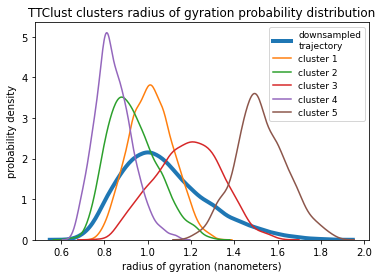

In [273]:
# plot c-alpha rg for each cluster and the whole trajectory
sns.kdeplot(data=rg_ds, label='downsampled\ntrajectory', linewidth=4)
sns.kdeplot(data=rg_ds[ttcc1], label='cluster 1')
sns.kdeplot(data=rg_ds[ttcc2], label='cluster 2')
sns.kdeplot(data=rg_ds[ttcc3], label='cluster 3')
sns.kdeplot(data=rg_ds[ttcc4], label='cluster 4')
sns.kdeplot(data=rg_ds[ttcc5], label='cluster 5')

plt.title('TTClust clusters radius of gyration probability distribution')
plt.xlabel('radius of gyration (nanometers)')
plt.ylabel('probability density')
plt.legend(fontsize=9)
plt.savefig(outdir+'/radgyrpdf.png')
plt.show()

rmsd from helix:

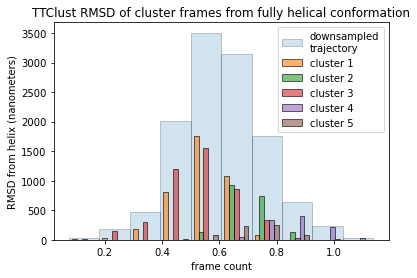

In [274]:
# plot histogram of helix RMSD for each cluster and the whole trajectory
plt.hist(rmsdH_ds,alpha=.2,lw=1,edgecolor='k',label="downsampled\ntrajectory")
plt.hist((rmsdH_ds[ttcc1],rmsdH_ds[ttcc2],rmsdH_ds[ttcc3],
          rmsdH_ds[ttcc4],rmsdH_ds[ttcc5]),alpha=.6,lw=1,edgecolor='k',
         label=("cluster 1","cluster 2","cluster 3","cluster 4","cluster 5"))
plt.title('TTClust RMSD of cluster frames from fully helical conformation')
plt.xlabel('frame count')
plt.ylabel('RMSD from helix (nanometers)')
plt.legend()
plt.savefig(outdir+'/helixRMSDhist.png')
plt.show()

secondary structure propensity:

In [275]:
# dssp apparently doesn't like .h5 files
trj_dsBBdcd = md.load('ntail.apo.protein.300K.dcd',top='Ntail.protein.pdb',stride=stride)
trj_dsBBdcd.restrict_atoms(trj_dsBBdcd.topology.select('protein and backbone and not index 310'))
trj_dsBBdcd = trj_dsBBdcd.center_coordinates()

/home/jwdell/anaconda3/envs/new_chem101/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


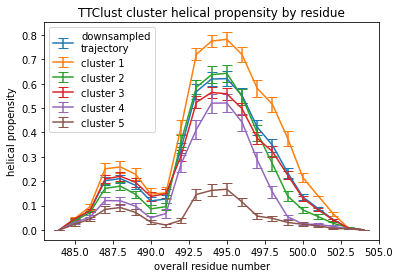

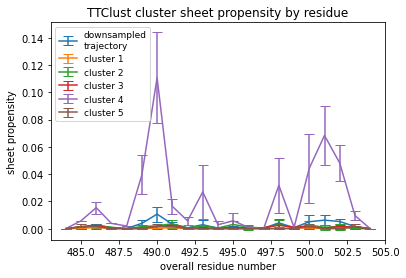

In [276]:
# compute secondary structure assignments
dssp = md.compute_dssp(trj_dsBBdcd)
h, e = dssp_convert(dssp)
dsspH = np.copy(dssp)

dsspc1 = dssp[ttcc1]
dsspc2 = dssp[ttcc2]
dsspc3 = dssp[ttcc3]
dsspc4 = dssp[ttcc4]
dsspc5 = dssp[ttcc5]
hc1, ec1 = dssp_convert(dsspc1)
hc2, ec2 = dssp_convert(dsspc2)
hc3, ec3 = dssp_convert(dsspc3)
hc4, ec4 = dssp_convert(dsspc4)
hc5, ec5 = dssp_convert(dsspc5)

# plot helical and sheet propensity (with error bars)
#  for each cluster and the whole trajectory
plt.errorbar(prot_res_ds, h[:,0], yerr=h[:,1], capsize=5, label='downsampled\ntrajectory')
plt.errorbar(prot_res_ds, hc1[:,0], yerr=hc1[:,1], capsize=5, label='cluster 1')
plt.errorbar(prot_res_ds, hc2[:,0], yerr=hc2[:,1], capsize=5, label='cluster 2')
plt.errorbar(prot_res_ds, hc3[:,0], yerr=hc3[:,1], capsize=5, label='cluster 3')
plt.errorbar(prot_res_ds, hc4[:,0], yerr=hc4[:,1], capsize=5, label='cluster 4')
plt.errorbar(prot_res_ds, hc5[:,0], yerr=hc5[:,1], capsize=5, label='cluster 5')

plt.title('TTClust cluster helical propensity by residue')
plt.legend()
plt.xlabel('overall residue number')
plt.ylabel('helical propensity')
plt.savefig(outdir+'/helprop.png')
plt.show()
plt.clf()

plt.errorbar(prot_res_ds, e[:,0], yerr=e[:,1], capsize=5, label='downsampled\ntrajectory')
plt.errorbar(prot_res_ds, ec1[:,0], yerr=ec1[:,1], capsize=5, label='cluster 1')
plt.errorbar(prot_res_ds, ec2[:,0], yerr=ec2[:,1], capsize=5, label='cluster 2')
plt.errorbar(prot_res_ds, ec3[:,0], yerr=ec3[:,1], capsize=5, label='cluster 3')
plt.errorbar(prot_res_ds, ec4[:,0], yerr=ec4[:,1], capsize=5, label='cluster 4')
plt.errorbar(prot_res_ds, ec5[:,0], yerr=ec5[:,1], capsize=5, label='cluster 5')

plt.title('TTClust cluster sheet propensity by residue')
plt.legend(loc='upper left',fontsize=9)
plt.xlabel('overall residue number')
plt.ylabel('sheet propensity')
plt.savefig(outdir+'/sheprop.png')
plt.show()

###### MDTraj Ward clusters (from ward_labels above)

In [277]:
outdir='mdtraj results'

In [278]:
# collect from labeled array by condition
#  (already zero-indexed because this is
#   just pulling indices from a numpy array)
mdtc1 = np.asarray(ward_labels==1).nonzero()[0]
mdtc2 = np.asarray(ward_labels==2).nonzero()[0]
mdtc3 = np.asarray(ward_labels==3).nonzero()[0]
mdtc4 = np.asarray(ward_labels==4).nonzero()[0]
mdtc5 = np.asarray(ward_labels==5).nonzero()[0]

radius of gyration:

In [279]:
# see above
print("C\u03B1 radii of gyration")
print("cluster 1: %.3lf"%np.average(rg[mdtc1]),"\u00B1 %.3lf"%block(rg[mdtc1])**.5)
print("cluster 2: %.3lf"%np.average(rg[mdtc2]),"\u00B1 %.3lf"%block(rg[mdtc2])**.5)
print("cluster 3: %.3lf"%np.average(rg[mdtc3]),"\u00B1 %.3lf"%block(rg[mdtc3])**.5)
print("cluster 4: %.3lf"%np.average(rg[mdtc4]),"\u00B1 %.3lf"%block(rg[mdtc4])**.5)
print("cluster 5: %.3lf"%np.average(rg[mdtc5]),"\u00B1 %.3lf"%block(rg[mdtc5])**.5)

Cα radii of gyration
cluster 1: 0.977 ± 0.004
cluster 2: 0.891 ± 0.005
cluster 3: 0.988 ± 0.005
cluster 4: 1.178 ± 0.007
cluster 5: 1.428 ± 0.006


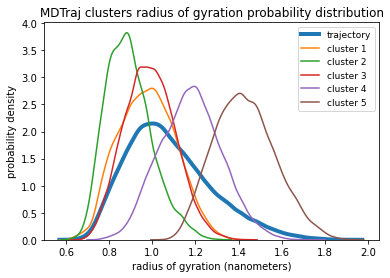

In [280]:
# see above
sns.kdeplot(data=rg, label='trajectory', linewidth=4)
sns.kdeplot(data=rg[mdtc1], label='cluster 1')
sns.kdeplot(data=rg[mdtc2], label='cluster 2')
sns.kdeplot(data=rg[mdtc3], label='cluster 3')
sns.kdeplot(data=rg[mdtc4], label='cluster 4')
sns.kdeplot(data=rg[mdtc5], label='cluster 5')

plt.title('MDTraj clusters radius of gyration probability distribution')
plt.xlabel('radius of gyration (nanometers)')
plt.ylabel('probability density')
plt.legend(fontsize=9)
plt.savefig(outdir+'/radgyrpdf.png')
plt.show()

rmsd from helix:

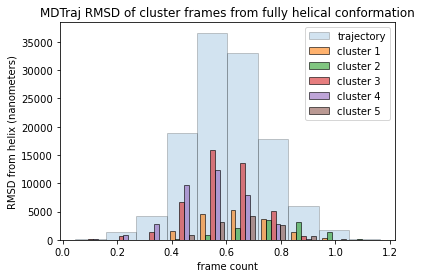

In [281]:
# see above
plt.hist(rmsdH,alpha=.2,lw=1,edgecolor='k',label="trajectory")
plt.hist((rmsdH[mdtc1],rmsdH[mdtc2],rmsdH[mdtc3],
          rmsdH[mdtc4],rmsdH[mdtc5]),alpha=.6,lw=1,edgecolor='k',
         label=("cluster 1","cluster 2","cluster 3","cluster 4","cluster 5"))
plt.title('MDTraj RMSD of cluster frames from fully helical conformation')
plt.xlabel('frame count')
plt.ylabel('RMSD from helix (nanometers)')
plt.legend()
plt.savefig(outdir+'/helixRMSDhist.png')
plt.show()

secondary structure propensity:

In [265]:
# see above
trjBBdcd = md.load('ntail.apo.protein.300K.dcd',top='Ntail.protein.pdb')
trjBBdcd.restrict_atoms(trjBBdcd.topology.select('protein and backbone and not index 310'))
trjBBdcd = trjBBdcd.center_coordinates()

/home/jwdell/anaconda3/envs/new_chem101/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


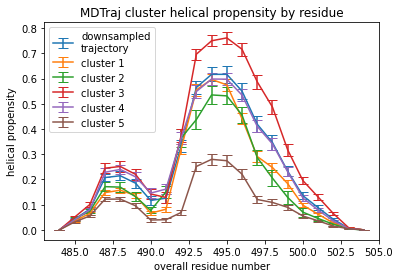

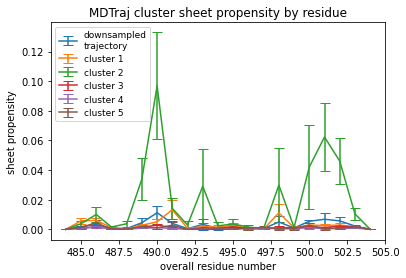

In [282]:
# see above
dssp = md.compute_dssp(trjBBdcd)
h, e = dssp_convert(dssp)
dsspH = np.copy(dssp)

dsspc1 = dssp[mdtc1]
dsspc2 = dssp[mdtc2]
dsspc3 = dssp[mdtc3]
dsspc4 = dssp[mdtc4]
dsspc5 = dssp[mdtc5]
hc1, ec1 = dssp_convert(dsspc1)
hc2, ec2 = dssp_convert(dsspc2)
hc3, ec3 = dssp_convert(dsspc3)
hc4, ec4 = dssp_convert(dsspc4)
hc5, ec5 = dssp_convert(dsspc5)

# see above
plt.errorbar(prot_res, h[:,0], yerr=h[:,1], capsize=5, label='downsampled\ntrajectory')
plt.errorbar(prot_res, hc1[:,0], yerr=hc1[:,1], capsize=5, label='cluster 1')
plt.errorbar(prot_res, hc2[:,0], yerr=hc2[:,1], capsize=5, label='cluster 2')
plt.errorbar(prot_res, hc3[:,0], yerr=hc3[:,1], capsize=5, label='cluster 3')
plt.errorbar(prot_res, hc4[:,0], yerr=hc4[:,1], capsize=5, label='cluster 4')
plt.errorbar(prot_res, hc5[:,0], yerr=hc5[:,1], capsize=5, label='cluster 5')

plt.title('MDTraj cluster helical propensity by residue')
plt.legend()
plt.xlabel('overall residue number')
plt.ylabel('helical propensity')
plt.savefig(outdir+'/helprop.png')
plt.show()
plt.clf()

plt.errorbar(prot_res, e[:,0], yerr=e[:,1], capsize=5, label='downsampled\ntrajectory')
plt.errorbar(prot_res, ec1[:,0], yerr=ec1[:,1], capsize=5, label='cluster 1')
plt.errorbar(prot_res, ec2[:,0], yerr=ec2[:,1], capsize=5, label='cluster 2')
plt.errorbar(prot_res, ec3[:,0], yerr=ec3[:,1], capsize=5, label='cluster 3')
plt.errorbar(prot_res, ec4[:,0], yerr=ec4[:,1], capsize=5, label='cluster 4')
plt.errorbar(prot_res, ec5[:,0], yerr=ec5[:,1], capsize=5, label='cluster 5')

plt.title('MDTraj cluster sheet propensity by residue')
plt.legend(loc='upper left',fontsize=9)
plt.xlabel('overall residue number')
plt.ylabel('sheet propensity')
plt.savefig(outdir+'/sheprop.png')
plt.show()

###### scikit-learn DBSCAN clusters (from db_labels above)

In [283]:
outdir='sklearnDBSCAN results'

In [284]:
# see above
skldbc0 = np.asarray(db_labels==0).nonzero()[0]
skldbc1 = np.asarray(db_labels==1).nonzero()[0]
skldbc2 = np.asarray(db_labels==2).nonzero()[0]
skldbc3 = np.asarray(db_labels==3).nonzero()[0]
skldbc4 = np.asarray(db_labels==4).nonzero()[0]

radius of gyration:

In [285]:
# see above
print("C\u03B1 radii of gyration")
print("cluster 0: %.3lf"%np.average(rg[skldbc0]),"\u00B1 %.3lf"%block(rg[skldbc0])**.5)
print("cluster 1: %.3lf"%np.average(rg[skldbc1]),"\u00B1 %.3lf"%block(rg[skldbc1])**.5)
print("cluster 2: %.3lf"%np.average(rg[skldbc2]),"\u00B1 %.3lf"%block(rg[skldbc2])**.5)
print("cluster 3: %.3lf"%np.average(rg[skldbc3]),"\u00B1 %.3lf"%block(rg[skldbc3])**.5)
print("cluster 4: %.3lf"%np.average(rg[skldbc4]),"\u00B1 %.3lf"%block(rg[skldbc4])**.5)

Cα radii of gyration
cluster 0: 1.090 ± 0.009
cluster 1: 0.853 ± 0.006
cluster 2: 0.906 ± 0.008
cluster 3: 1.049 ± 0.008
cluster 4: 1.175 ± 0.009


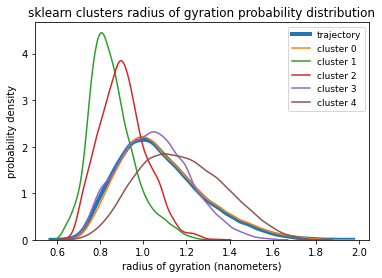

numbers of frames
cluster 0: 82475
cluster 1: 3711
cluster 2: 3296
cluster 3: 13351
cluster 4: 11813


In [286]:
# see above
sns.kdeplot(data=rg, label='trajectory', linewidth=4)
sns.kdeplot(data=rg[skldbc0], label='cluster 0')
sns.kdeplot(data=rg[skldbc1], label='cluster 1')
sns.kdeplot(data=rg[skldbc2], label='cluster 2')
sns.kdeplot(data=rg[skldbc3], label='cluster 3')
sns.kdeplot(data=rg[skldbc4], label='cluster 4')

plt.title('sklearn clusters radius of gyration probability distribution')
plt.xlabel('radius of gyration (nanometers)')
plt.ylabel('probability density')
plt.legend(fontsize=9)
plt.savefig(outdir+'/radgyrpdf.png')
plt.show()

print("numbers of frames")
print("cluster 0:",np.size(skldbc0))
print("cluster 1:",np.size(skldbc1))
print("cluster 2:",np.size(skldbc2))
print("cluster 3:",np.size(skldbc3))
print("cluster 4:",np.size(skldbc4))

Presumably due to the density-based nature of this algorithm, certain clusters encompass many more samples than others.

This is why clusters 3 and 4 and ESPECIALLY cluster 0 appear to be very close to the overall ensemble distribution; we can assume they correspond to particularly low free energy conformations (not sure how to demonstrate that within the scope of this project).

rmsd from helix:

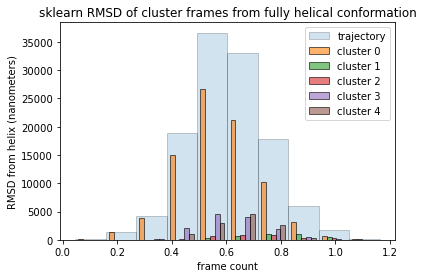

In [288]:
# see above
plt.hist(rmsdH,alpha=.2,lw=1,edgecolor='k',label="trajectory")
plt.hist((rmsdH[skldbc0],rmsdH[skldbc1],rmsdH[skldbc2],
          rmsdH[skldbc3],rmsdH[skldbc4]),alpha=.6,lw=1,edgecolor='k',
         label=("cluster 0","cluster 1","cluster 2","cluster 3","cluster 4"))
plt.title('sklearn RMSD of cluster frames from fully helical conformation')
plt.xlabel('frame count')
plt.ylabel('RMSD from helix (nanometers)')
plt.legend()
plt.savefig(outdir+'/helixRMSDhist.png')
plt.show()

secondary structure propensity:

/home/jwdell/anaconda3/envs/new_chem101/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


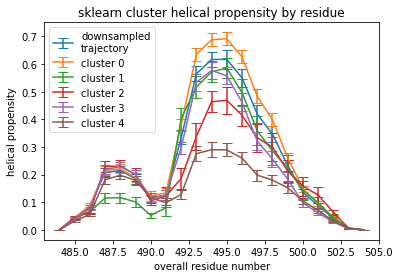

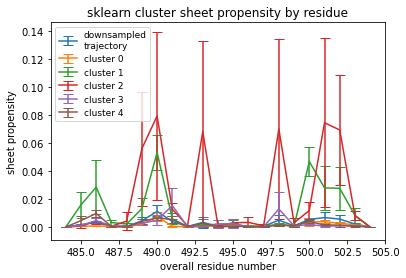

In [290]:
# see above
dssp = md.compute_dssp(trjBBdcd)
h, e = dssp_convert(dssp)
dsspH = np.copy(dssp)

dsspc0 = dssp[skldbc0]
dsspc1 = dssp[skldbc1]
dsspc2 = dssp[skldbc2]
dsspc3 = dssp[skldbc3]
dsspc4 = dssp[skldbc4]
hc0, ec0 = dssp_convert(dsspc0)
hc1, ec1 = dssp_convert(dsspc1)
hc2, ec2 = dssp_convert(dsspc2)
hc3, ec3 = dssp_convert(dsspc3)
hc4, ec4 = dssp_convert(dsspc4)

# see above
plt.errorbar(prot_res, h[:,0], yerr=h[:,1], capsize=5, label='downsampled\ntrajectory')
plt.errorbar(prot_res, hc0[:,0], yerr=hc0[:,1], capsize=5, label='cluster 0')
plt.errorbar(prot_res, hc1[:,0], yerr=hc1[:,1], capsize=5, label='cluster 1')
plt.errorbar(prot_res, hc2[:,0], yerr=hc2[:,1], capsize=5, label='cluster 2')
plt.errorbar(prot_res, hc3[:,0], yerr=hc3[:,1], capsize=5, label='cluster 3')
plt.errorbar(prot_res, hc4[:,0], yerr=hc4[:,1], capsize=5, label='cluster 4')

plt.title('sklearn cluster helical propensity by residue')
plt.legend()
plt.xlabel('overall residue number')
plt.ylabel('helical propensity')
plt.savefig(outdir+'/helprop.png')
plt.show()
plt.clf()

plt.errorbar(prot_res, e[:,0], yerr=e[:,1], capsize=5, label='downsampled\ntrajectory')
plt.errorbar(prot_res, ec0[:,0], yerr=ec0[:,1], capsize=5, label='cluster 0')
plt.errorbar(prot_res, ec1[:,0], yerr=ec1[:,1], capsize=5, label='cluster 1')
plt.errorbar(prot_res, ec2[:,0], yerr=ec2[:,1], capsize=5, label='cluster 2')
plt.errorbar(prot_res, ec3[:,0], yerr=ec3[:,1], capsize=5, label='cluster 3')
plt.errorbar(prot_res, ec4[:,0], yerr=ec4[:,1], capsize=5, label='cluster 4')

plt.title('sklearn cluster sheet propensity by residue')
plt.legend(loc='upper left',fontsize=9)
plt.xlabel('overall residue number')
plt.ylabel('sheet propensity')
plt.savefig(outdir+'/sheprop.png')
plt.show()